# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train_sam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 19            
model_seed = 9                  

# --- Training configuration ---
epochs = 1000            

# --- Dataset configuration ---
base_data_size = 20      
dataset_type = "data"   
dataset_quantities = [0, 30, 100, 300, 700]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    



## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train_sam(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


[SAM] Epoch 1/1000: Train Loss 0.6956 | Test Loss 0.6954 | accs Train 0.5000 Test 0.5000
[SAM] Epoch 100/1000: Train Loss 0.1939 | Test Loss 1.8538 | accs Train 0.9500 Test 0.5595
[SAM] Epoch 200/1000: Train Loss 0.0705 | Test Loss 3.0925 | accs Train 1.0000 Test 0.5695
[SAM] Epoch 300/1000: Train Loss 0.0265 | Test Loss 3.8318 | accs Train 1.0000 Test 0.5773
[SAM] Epoch 400/1000: Train Loss 0.0084 | Test Loss 4.6294 | accs Train 1.0000 Test 0.5740
[SAM] Epoch 500/1000: Train Loss 0.0038 | Test Loss 5.1748 | accs Train 1.0000 Test 0.5667
[SAM] Epoch 600/1000: Train Loss 0.0022 | Test Loss 5.2958 | accs Train 1.0000 Test 0.5695
[SAM] Epoch 700/1000: Train Loss 0.0012 | Test Loss 5.7846 | accs Train 1.0000 Test 0.5713
[SAM] Epoch 800/1000: Train Loss 0.0008 | Test Loss 5.8223 | accs Train 1.0000 Test 0.5780
[SAM] Epoch 900/1000: Train Loss 0.0006 | Test Loss 6.2067 | accs Train 1.0000 Test 0.5777
[SAM] Epoch 1000/1000: Train Loss 0.0004 | Test Loss 6.5093 | accs Train 1.0000 Test 0.5757


[SAM] Epoch 100/500: Train Loss 0.4843 | Test Loss 0.7205 | accs Train 0.7500 Test 0.5990


[SAM] Epoch 200/500: Train Loss 0.3492 | Test Loss 0.8688 | accs Train 0.8500 Test 0.6080


[SAM] Epoch 300/500: Train Loss 0.1746 | Test Loss 0.9961 | accs Train 0.9000 Test 0.6585


[SAM] Epoch 400/500: Train Loss 0.0722 | Test Loss 1.0433 | accs Train 1.0000 Test 0.6973


[SAM] Epoch 500/500: Train Loss 0.0288 | Test Loss 1.0671 | accs Train 1.0000 Test 0.7248
Completed training with 0 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.6985 | Test Loss 0.6951 | accs Train 0.4633 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.5615 | Test Loss 0.6071 | accs Train 0.7150 Test 0.6647


[SAM] Epoch 200/500: Train Loss 0.2785 | Test Loss 0.3102 | accs Train 0.9433 Test 0.9295


[SAM] Epoch 300/500: Train Loss 0.0450 | Test Loss 0.0552 | accs Train 0.9917 Test 0.9882


[SAM] Epoch 400/500: Train Loss 0.0148 | Test Loss 0.0243 | accs Train 1.0000 Test 0.9968


[SAM] Epoch 500/500: Train Loss 0.0048 | Test Loss 0.0136 | accs Train 1.0000 Test 0.9968
Completed training with 540 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.6983 | Test Loss 0.6951 | accs Train 0.4665 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.5883 | Test Loss 0.5935 | accs Train 0.6735 Test 0.6685


[SAM] Epoch 200/500: Train Loss 0.1832 | Test Loss 0.1871 | accs Train 0.9810 Test 0.9768


[SAM] Epoch 300/500: Train Loss 0.0302 | Test Loss 0.0338 | accs Train 0.9985 Test 0.9980


[SAM] Epoch 400/500: Train Loss 0.0128 | Test Loss 0.0151 | accs Train 0.9990 Test 0.9985


[SAM] Epoch 500/500: Train Loss 0.0046 | Test Loss 0.0059 | accs Train 0.9995 Test 0.9995
Completed training with 1940 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.6973 | Test Loss 0.6951 | accs Train 0.4807 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.5879 | Test Loss 0.5941 | accs Train 0.6742 Test 0.6685


[SAM] Epoch 200/500: Train Loss 0.2470 | Test Loss 0.2548 | accs Train 0.9655 Test 0.9560


[SAM] Epoch 300/500: Train Loss 0.0441 | Test Loss 0.0469 | accs Train 0.9978 Test 0.9965


[SAM] Epoch 400/500: Train Loss 0.0076 | Test Loss 0.0098 | accs Train 0.9988 Test 0.9982


[SAM] Epoch 500/500: Train Loss 0.0022 | Test Loss 0.0039 | accs Train 0.9997 Test 0.9988
Completed training with 5940 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.6973 | Test Loss 0.6951 | accs Train 0.4798 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.5937 | Test Loss 0.5924 | accs Train 0.6669 Test 0.6693


[SAM] Epoch 200/500: Train Loss 0.1778 | Test Loss 0.1753 | accs Train 0.9807 Test 0.9798


[SAM] Epoch 300/500: Train Loss 0.0214 | Test Loss 0.0226 | accs Train 0.9987 Test 0.9982


[SAM] Epoch 400/500: Train Loss 0.0057 | Test Loss 0.0067 | accs Train 0.9990 Test 0.9985


[SAM] Epoch 500/500: Train Loss 0.0029 | Test Loss 0.0039 | accs Train 0.9994 Test 0.9990
Completed training with 19940 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.6971 | Test Loss 0.6951 | accs Train 0.4815 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.5910 | Test Loss 0.5861 | accs Train 0.6622 Test 0.6675


[SAM] Epoch 200/500: Train Loss 0.1936 | Test Loss 0.1927 | accs Train 0.9794 Test 0.9728


[SAM] Epoch 300/500: Train Loss 0.0310 | Test Loss 0.0329 | accs Train 0.9983 Test 0.9982


[SAM] Epoch 400/500: Train Loss 0.0074 | Test Loss 0.0092 | accs Train 0.9988 Test 0.9982


[SAM] Epoch 500/500: Train Loss 0.0122 | Test Loss 0.0137 | accs Train 0.9991 Test 0.9985
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 6.5093 | accs: 0.5757
  30 samples | Test Loss: 2.5531 | accs: 0.7470
 100 samples | Test Loss: 0.6571 | accs: 0.8840
 300 samples | Test Loss: 0.0199 | accs: 0.9948
 700 samples | Test Loss: 0.0041 | accs: 0.9982

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0004 | accs: 1.0000
 Model   30 | Train Loss: 0.0008 | accs: 1.0000
 Model  100 | Train Loss: 0.0096 | accs: 1.0000
 Model  300 | Train Loss: 0.0001 | accs: 1.0000
 Model  700 | Train Loss: 0.0006 | accs: 1.0000

Dataset type: data, additional samples: 30
 Model    0 | Train Loss: 2.9826 | accs: 0.8600
 Model   30 | Train Loss: 0.0006 | accs: 1.0000
 Model  100 | Train Loss: 0.0068 | accs: 1.0000
 Model  300 | Train Loss: 0.0001 | accs: 1.0000
 Model  700 | Train Loss: 0.0004 | accs: 1.0000

Dataset type: data, additional samples: 100
 Model    0 | Train Loss: 4.3581 | accs: 0.7000
 Model   30 | Train Loss: 0.

 Model 19940 | Train Loss: 0.0029 | accs: 0.9994
 Model 59940 | Train Loss: 0.0124 | accs: 0.9990

Dataset type: data, additional samples: 59940


 Model    0 | Train Loss: 1.0350 | accs: 0.7311
 Model  540 | Train Loss: 0.0105 | accs: 0.9983
 Model 1940 | Train Loss: 0.0048 | accs: 0.9998


 Model 5940 | Train Loss: 0.0024 | accs: 0.9995
 Model 19940 | Train Loss: 0.0028 | accs: 0.9996


 Model 59940 | Train Loss: 0.0120 | accs: 0.9992


### Model + Data Specific Verification

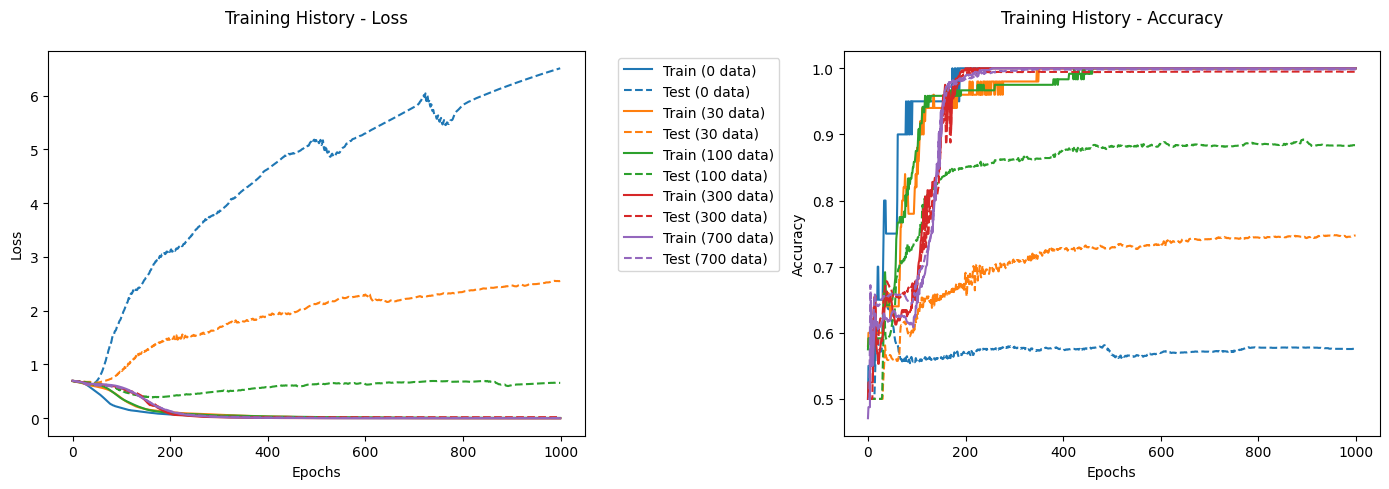

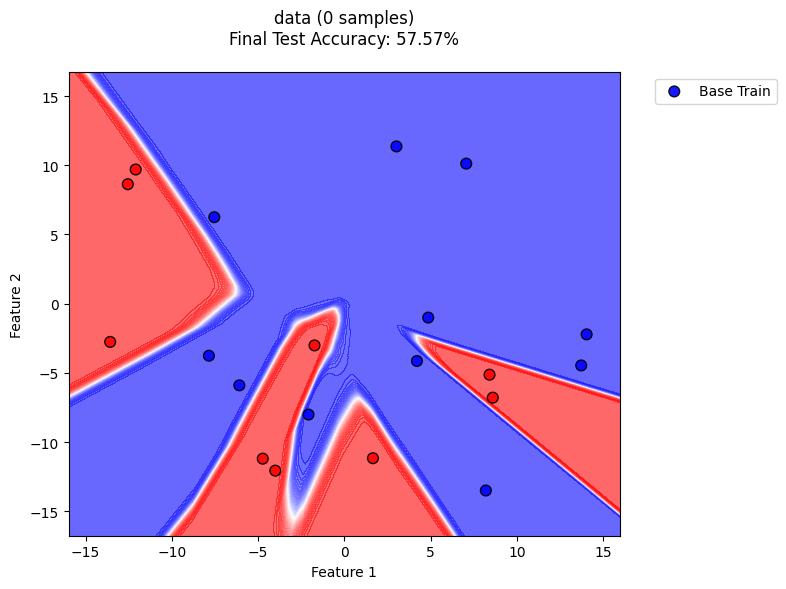

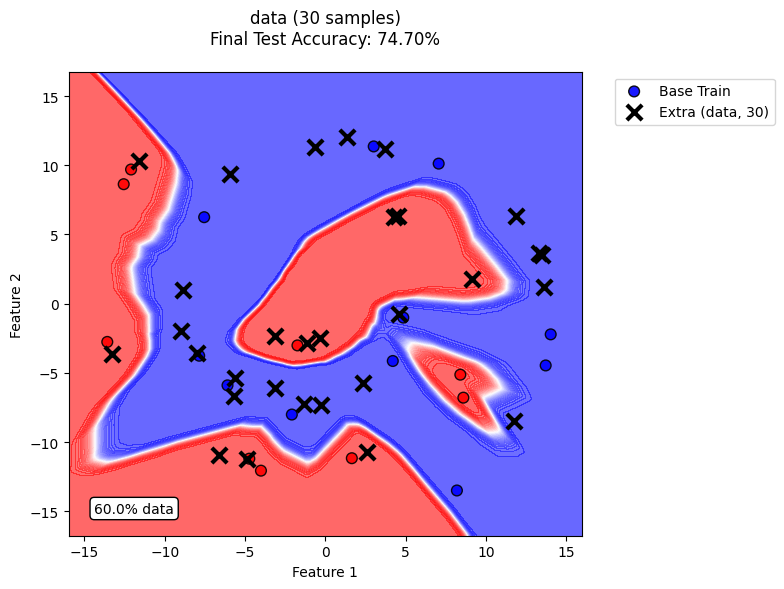

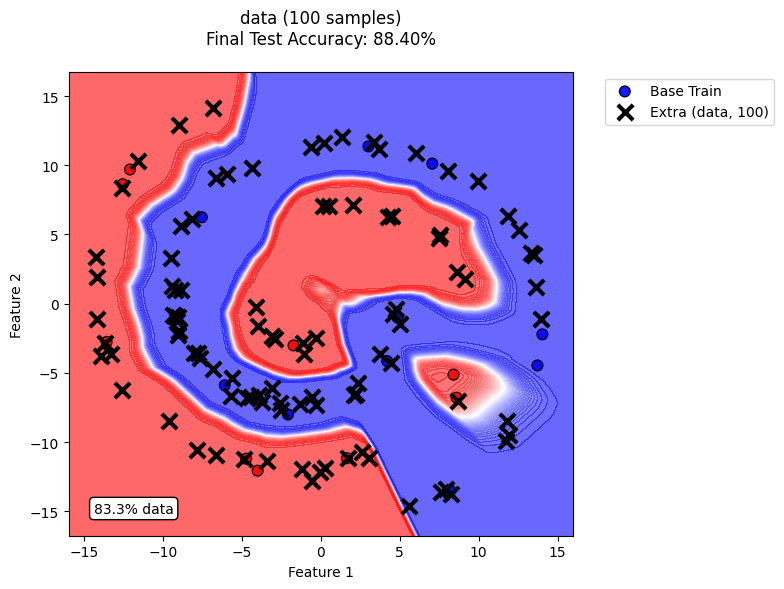

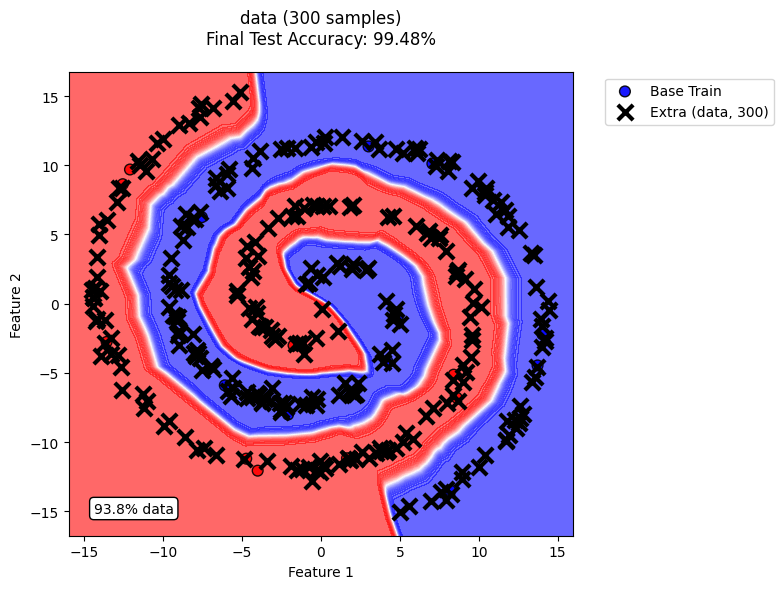

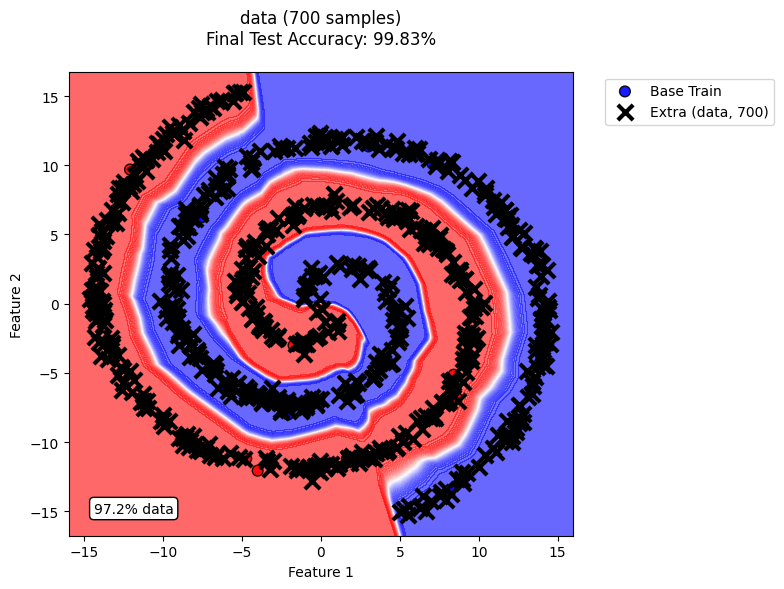

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_30.pt
Saved model: models_and_data/model_additional_30.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
✅ Model saved to models_and_data\model_additional_300.pt
Saved model: models_and_data/model_additional_300.pt
✅ Model saved to models_and_data\model_additional_700.pt
Saved model: models_and_data/model_additional_700.pt
